his is a general purpose image classifier. No intimate knowledge of neural networks is required to use this program to do image classification. A limited knowledge ofpython may be required. The program uses a modfied version of the MobileNet CNN. Top layers of the networkare modified as required for the classification task specifics. Image Inputs and Storage Locations: The are two modes by which input images can be supplies as indicated by the call parameter mode. First create a directory to hold all the files

I refer to this as the source_dir. Files in the source directory may be stored in one of two ways. If the parameter mode='SEP' then within the source_dir you must have 3 subdirectoriesw specifically named as train, test and valid. The train sub directory should contain the training images. The test sub directory should contain the test images and the valid sub directory should contain the validation images. Within each of these the subdirectories are identically named 'class' sub directories. For example if your trying to classify images as to whether it is a dog or a cat you would create class sub directories Cats and Dogs in the train, test and valid directories. Store the cat training images in the train directory within the Cats subdirectory, similarly for the dog training images in the Dogs subdirectory. Do the same for the test and validation images respectively.

If the parameter mode='All' the source_dir must have a single subdirectory named consolidated. All image files are stored in this subdirectory. Within the consolidated sub directory are 'class' subdirectories, one subdirectory per class. For the dog/cat example there would be a class subdirectory Cats and a class sub directory Dogs. All cat images should be placed in the Cats sub directory and similarly for dog images in the Dogs subdirectory. A training set and a validation set are created from these images based on the parameter split. Split is an integer value between 0 and 100 and indicates the percentage of images which will be used to create the validation set of images. A typical value might be 15. Parameter split is not used when the parameter mode is set to "SEP".

USE: status=TF2_classify(source_dir,output_dir,subject, split, epochs,lr_rate,image_size, model_size, dropout, rand_seed,dwell, kaggle)

where: souurce_dir is a string indicating the full path to where your image files are stored output_dir is a string indicating the full path where output files will be stored.

The program will create the following output files: the trained model file labeled in the form subject-model_size-image_size-accuracy.h5. For example a file named birds-s-224-98.66.h5 is the trained model with the subject birds, model size of s for small model, images size of 224 pixels and a test accuracy of 9.66%. a text file labeled as subject-numberof classes.txt. For example a file labeled birds-200.txt is a file where the subject was birds and there are 200 classes of birds Note: the above two files are used by a companion program Predictions.py which uses the trained model to make predictions on input bird image files.

An optional file may also be produced labelled error list-model_size-accuracy.txt. This file contains a listing of all test files that were classified incorrectly.

subject is a string indicating the subject of the classification. For example if classifying bird species you might use "birds" as the subject. split is an integer between 0 and 100. AS noted above it defines the percentage of files in the consolidated directory that will be used as validation files when mode is set to "All". It is not used if mode is setto "SEP" epochs - is an integer and specifies the number of epochs for training. At the end of the training the test set accuracy is determined and the result is printed. Based on the result the user is given the option to enter an integer value for the number of additional training epochs you may wish to run. This is convenient if the accuracy achieved was below that desired and you want to continue training for more epochs.

lr_rate is a float that indicates the initial learning rate for the network. A good value to use is .002. During training the learning rate is automatically adjusted based on training and validation accuracy.

image_size is an integer indicating the size of images to be used by the model. Allowable values are 224, 192, 160 or 128. This limitation is present so that the model can load the pre=trained weights from Imagnet which enables faster convergence.

model_size is a string limited to one of the single charactrs "S", "M", or "L". When set to "S" a small model is used, when set to "M" a medium size model is used. When set to "L" a large model is used. All models use the MobilNet model as the base model and add top layers to achieve different levels of model complexity. It is best to set model_size="S" initially. Only use the larger models if the training results are unsatisfactory.

dropout is a float value between 0.0 and 1.0. A good value to use is .4. Dropout is used when you are using a medium or larger model and you experience over fitting.

rand_seed is an integer used to set the seed for randomization processes. It's value is arbitrary.

dwell is a boolean, either set to True or False. Normally set it to false. dwell is used as an experimental parameter that modifies the training scheme. You may try setting dwell=True and see if you get a better result for Validation accuracy.

kagle is a boolean set to either True or False. Normally set kagle=False. This parameter should only be set to trueif you are on the kagle websiteandrunninga "commit" on your kernel.

In Process Printed Outputs: This programs checks input parameters for errors. If an error is detected a message is printed and the functions returns False. If all input are correct training is initiated.

During training information is printed out at the end of each epoch that shows the training loss and accuracy and the validation loss and accuracy. When all epochs are completed the test set is predicted and the accuracy on the test set is provided. You can optionally save a list of errors as a file in the output_dir.

After running the test set you are given the option to halt or to enter an integer that indicates how many additional epochs you want to train for.

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import pytz
import os
# from google.colab import drive
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
def wrapup (output_dir,subject, accuracy, image_size, model, weights,run_num, kaggle):
    if accuracy >= 95:
        msg=f'With an accuracy of {accuracy:5.2f} % the results appear satisfactory'
        print_in_color(msg, (0,255,0),(0,0,0))
        if kaggle:
            save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights)            
            print ('*********************Process is completed******************************')            
            return [False, None]        
    elif accuracy >=85 and accuracy < 95:
        if kaggle:
            if run_num==2:
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [False, None]
            else:
                print('running for 6 more epochs to see if accuracy improves')
                return[True,6] # run for 8 more epochs
        else:
            msg=f'With an accuracy of {accuracy:5.2f} % the results are mediocure. Try running more epochs'
            print_in_color(msg, (255,0,0),(0,0,0))
            
    else:
        if kaggle:
            if run_num==2:
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [False, None]
            else:
                print('Running for 8 more epochs to see if accuracy improves')
                return[True,8] # run for 8 more epochs
        else:
            msg=f'With an accuracy  of {accuracy:5.2f} % the results would appear to be unsatisfactory'
            print_in_color(msg, (255,0,0),(0,0,0))
            msg='You might try to run for more epochs or get more training data '
            msg=msg + 'or perhaps crop your images so the desired subject takes up most of the image'
            print_in_color(msg, (255,255,255), (0,0,0))
            
    
    tryagain=True
    if kaggle==False:
        while tryagain==True:
            ans=input('To continue training from where it left off enter the number of additional epochs or enter H to halt  ')
            if ans =='H' or ans == 'h':
                run=False
                tryagain=False
                save_model(output_dir, subject, accuracy, image_size ,model_size, model, weights) 
                print ('*********************Process is completed******************************')
                return [run,None]
            else:
                try:
                    epochs=int(ans)
                    run=True
                    tryagain=False
                    return [run,epochs]
                except ValueError:
                    msg=f'\nyour entry {ans} was neither H nor an integer- re-enter your response'
                    print_in_color(msg, (255,0,0), (0,0,0))

In [19]:
def display_pred(output_dir, pred, file_names, labels, subject, model_size,classes, kaggle):    
    trials=len(labels)
    errors=0
    e_list=[]
    prob_list=[]
    true_class=[]
    pred_class=[]
    x_list=[]
    index_list=[]
    pr_list=[]
    error_msg=''    
    for i in range (0,trials):
        p_class=pred[i].argmax()
        if p_class !=labels[i]: #if the predicted class is not the same as the test label it is an error
            errors=errors + 1
            fname=os.path.basename(file_names[i])
            e_list.append(fname)  # list of file names that are in error
            true_class.append(classes[labels[i]]) # list classes that have an eror
            pred_class.append(classes[p_class]) #class the prediction selected
            prob_list.append(100 *pred[i][p_class])# probability of the predicted class
            add_msg='{0:^24s}{1:5s}{2:^20s}\n'.format(classes[labels[i]], ' ', file_names[i])
            error_msg=error_msg + add_msg
            
    accuracy=100*(trials-errors)/trials
    msg=f'\n There were {errors} errors in {trials} trials for an accuracy of {accuracy:7.3f}'
    print_in_color(msg, (0,255,0),(0,0,0))
    if kaggle==True and errors<26:
        ans='Y'
    else:
        ans='N'
    if kaggle==False:
        ans=input('To see a listing of prediction errors enter Y to skip press Enter\n ')
    if ans== 'Y' or ans  =='y':
        msg='{1:^20s}{0:3s}{2:^20s}{0:3s}{3:^20s}{0:5s}{4}'
        msg=msg.format( ' ', 'File Name', 'True Class', 'Predicted Class', 'Probability')
        print_in_color(msg, (0,0,255), (255,255,0))
        for i in range(0,errors):
            msg='{0}{1:^20s}{0:3s}{2:^20s}{0:3s}{3:^20s}{0:5s}{4:^6.2f}'
            print (msg.format(' ',e_list[i], true_class[i], pred_class[i], prob_list[i]))
    if kaggle==True:
        ans='Y'
    else:
        ans=input('\nDo you want to save the list of error files?. Enter Y to save or press Enter to not save  ')
    if ans=='Y' or ans=='y':
        acc='{0:6.2f}'.format(accuracy)
        if model_size=='L':
            ms='Large'
        elif model_size=='M':
            ms= 'Medium'
        else:
            ms= 'Small'
        header='Classification subject: {0} There were {1} errors in {2} tests for an accuracy of {3} using a {4} model\n'.format(subject,errors,trials,acc,ms)
        header= header +'{0:^24s}{1:5s}{2:^20s}\n'.format('CLASS',' ', 'FILENAME') 
        error_msg=header + error_msg
        file_id='error list-' + model_size + acc +'.txt'
        file_path=os.path.join(output_dir,file_id)
        f=open(file_path, 'w')
        f.write(error_msg)
        f.close()
    for c in classes:
        count=true_class.count(c)
        x_list.append(count)
        pr_list.append(c)
    for i in range(0, len(x_list)):  # only plot classes that have errors
        if x_list[i]==0:
            index_list.append(i)
    for i in sorted(index_list, reverse=True):  # delete classes with no errors
        del x_list[i]
        del pr_list[i]      # use pr_list - can't change class_list must keep it fixed
    fig=plt.figure()
    fig.set_figheight(len(pr_list)/4)
    fig.set_figwidth(6)
    plt.style.use('fivethirtyeight')
    for i in range(0, len(pr_list)):
        c=pr_list[i]
        x=x_list[i]
        plt.barh(c, x, )
        plt.title( subject +' Classification Errors on Test Set')
    if errors>0:
        plt.show()
    if kaggle==False:
        ans=input('Press Enter to continue')
    return accuracy        

In [20]:
def save_model(output_dir,subject, accuracy, image_size,model_size, model, weights):
    # save the model with the  subect-accuracy.h5
    acc=str(accuracy)[0:5]
    id=subject + '-' + model_size + '-' +str(image_size) + '-' + acc + '.h5'    
    model.set_weights(weights)
    model_save_path=os.path.join(output_dir,id)    
    model.save(model_save_path)  

    # Convert the model to tflite and save it 11/28 JJM
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    id=subject + '-' + model_size + '-' +str(image_size) + '-' + acc + '.tflite'    
    model_save_path=os.path.join(output_dir,id)    
    with open(model_save_path, 'wb') as f:
      f.write(tflite_model)

In [21]:
def make_predictions( model, weights, test_gen, lr):
    config = model.get_config()
    pmodel = Model.from_config(config)  # copy of the model
    pmodel.set_weights(weights) #load saved weights with lowest validation loss
    pmodel.compile(Adam(lr=lr), loss='categorical_crossentropy', metrics=['accuracy'])    
    print('Training has completed. Now loading test set to see how accurate the model is')
    results=pmodel.evaluate(test_gen, verbose=0)
    accuracy=results[1]*100
    print('Model accuracy on Test Set is {0:7.2f} %'.format(results[1]* 100))
    predictions=pmodel.predict_generator(test_gen, verbose=0)        
    return (predictions,accuracy)

In [22]:
def tr_plot(tacc,vacc,tloss,vloss):
    #Plot the training and validation data
    Epoch_count=len(tloss)
    Epochs=[]
    for i in range (0,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    val_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,val_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [23]:
def train(model, callbacks, generators, epochs,start_epoch):
    # steps_list[0]=training steps, steps_list[2]=validations steps
    start=time.time()
    data = model.fit_generator(generator = generators[0], validation_data= generators[2], 
                               epochs=epochs, initial_epoch=start_epoch,
                               callbacks = callbacks, verbose=1)
    #data=model.fit(x=generators[0],  epochs=epochs, verbose=1, 
    #               callbacks=callbacks,  validation_data=generators[2], shuffle=True,  initial_epoch=start_epoch) 
       
    stop=time.time()
    duration = stop-start
    hrs=int(duration/3600)
    mins=int((duration-hrs*3600)/60)
    secs= duration-hrs*3600-mins*60
    msg=f'Training took\n {hrs} hours {mins} minutes and {secs:6.2f} seconds'
    print_in_color(msg, (0,0,255),(0,0,0))
    return data

In [24]:
def make_model(classes,lr_rate, image_size,model_size,dropout, rand_seed):
    size=len(classes)
    mobile = tf.keras.applications.mobilenet.MobileNet( include_top=False,
                                                           input_shape=(image_size,image_size,3),
                                                           pooling='max', weights='imagenet',
                                                           alpha=1, depth_multiplier=1,dropout=.4)
    x=mobile.layers[-1].output
    if model_size=='S':
        pass
       # x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                #bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
        #x=Dropout(rate=dropout, seed=rand_seed)(x) 
    elif model_size=='M':
        x=Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x) 
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(16, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)
    else:
        x=Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x) 
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(128, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)
        x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
        x=Dense(16, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006),activation='relu')(x)
        x=Dropout(rate=dropout, seed=rand_seed)(x)        
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    predictions=Dense (len(classes), activation='softmax')(x)
    model = Model(inputs=mobile.input, outputs=predictions)    
    for layer in model.layers:
        layer.trainable=True
    model.compile(Adamax(lr=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

In [25]:
def make_generators( paths, mode, split, classes, image_size, rand_seed):
    #paths[0]=train path,paths[1]=test path paths[2]= valid path paths[3]=classes
    split=split/100.0    
    if image_size==224:
        batch_size=85
    elif image_size==192:
        batch_size=120
    elif image_size==160:
        batch_size=170
    else:
        batch_size=260
    if mode == 'SEP': 
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(paths[0],
                target_size=(image_size, image_size), batch_size=batch_size, seed=rand_seed, class_mode='categorical', color_mode='rgb')
        
        valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input) .flow_from_directory(paths[2], 
                target_size=(image_size, image_size), batch_size=batch_size,
                seed=rand_seed, class_mode='categorical',color_mode='rgb', shuffle=False)
        
        test_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(paths[1],
                target_size=(image_size, image_size), batch_size=batch_size, class_mode='categorical',color_mode='rgb',
                seed=rand_seed, shuffle=False )
        file_names=test_gen.filenames          
        labels=test_gen.labels               
        return [[train_gen, test_gen, valid_gen], file_names, labels]                  
    else:        
        # all data is in a single directory there are no test images use validation images as test images
        train_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                             validation_split=split).flow_from_directory(paths[0],
                                                                                    target_size=(image_size, image_size),
                                                                                    batch_size=batch_size,
                                                                                    subset='training',seed=rand_seed)
        valid_gen=ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input,
                                    validation_split=split).flow_from_directory(paths[0],
                                                                                    target_size=(image_size, image_size),
                                                                                    batch_size=batch_size,
                                                                                    subset='validation',
                                                                                    seed=rand_seed, shuffle=False)
        file_names= valid_gen.filenames
        labels= valid_gen.labels
    return [[train_gen, valid_gen, valid_gen], file_names, labels]

In [26]:
def get_paths(source_dir,output_dir,mode,subject,classes): 
    class_count=len(classes)
    if mode =='ALL':
        # all data is in a single directory must be split into train, test, valid data sets 
        train_path=source_dir
        test_path=None        
        valid_path=None       
    else:
        # data is seperated in 3 directories train, test, valid
        test_path=os.path.join(source_dir,'test')
        train_path=os.path.join(source_dir, 'train')
        valid_path=os.path.join(source_dir,'valid')                  
    # save the class dictionary as a text file so it can be used by predictor.py in the future
    #saves file as subject.txt  structure is similar to a python dictionary
    msg=''
    for i in range(0, class_count):
        msg=msg + str(i) + ':' + classes[i] +','
    id=subject +'-' + str(class_count)  + '.txt'   
    dict_path=os.path.join (output_dir, id)
    f=open(dict_path, 'w')
    f.write(msg)
    f.close()    
    return [train_path, test_path, valid_path]
      

In [27]:
def check_inputs(source_dir, out_dir, split, image_size,model_size,dropout):
    status=True
    if os.path.isdir(source_dir)==False:
        msg=f'The source directory you specified {source_dir} does not exist - program terminating'
        status=False
    elif len(os.listdir(source_dir))<2:
        msg=f'directory {source_dir} must have at least 2 sub directories'
        status=False
    elif image_size not in [224,192,160,128]:
        msg=f'the images size you specified {image_size} is not one of 224,192,160 or 128 - program terminating' 
        status=False
    elif dropout <0.0 or dropout>1.0:
        msg=f'The drop out value you specified {dropout} must be a value between 0.0 and 1.0 - program terminating'
        status=False
    elif model_size not in ['L', 'M', 'S']:
        msg=f'The model size you specified {model_size} must be as single charater string either L, M, or S'
        status=False
    elif os.path.isdir(out_dir)==False:
        msg=f'The output directory you specified {out_dir} does not exist - program terminating'
        status=False
    else:        
        status=True
        msg=f'ERROR you must have a test, train and a valid subdirectory in {source_dir}'
        source_list=os.listdir(source_dir)       
        if ('test' in source_list and 'train' not in source_list) or ('test' in source_list and 'valid' not in source_list):
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                
        elif ('train' in source_list and 'test' not in source_list) or ('train' in source_list and 'valid' not in source_list):
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                
        elif ('valid' in source_list and 'train' not in source_list) or ('valid' in source_list and 'test' not in source_list): 
            print_in_color(msg,(255,0,0),(0,0,0))
            status=False                 
        else: 
            if 'test' in source_list:
                test_path=os.path.join(source_dir,'test')
                train_path=os.path.join(source_dir,'train')
                valid_path=os.path.join(source_dir,'valid')
                test_list=sorted(os.listdir(test_path))
                train_list=sorted(os.listdir(train_path))
                valid_list=sorted(os.listdir(valid_path)) 
                for i in range (0, len(test_list)):
                    if test_list[i] != train_list[i] or test_list[i] !=valid_list[i] or train_list[i] != valid_list[i]:
                        print(i, test_list[i], train_list[i], valid_list[i])
                if train_list != test_list or train_list != valid_list or test_list !=valid_list:
                    status=False
                    msg='class directories must have identical names in the train, test and valid directories- program terminating'
                elif len(test_list) <2 or len(valid_list)<2 or len(train_list)<2:
                    status=False
                    msg=' the train, test and valid directories must have at least 2 class sub directories - program terminating'
            else:
                if len(os.listdir(source_dir))<2:
                    msg=f'The must be at least 2 subdirectories in {source_dir}'
                    status=False
                elif split==None or split<1 or split>100:
                    msg=f'the split parameter you specied {split} must be between 0 and 100 when class directories are in the source directory- program terminating'
                    status=False
                else:
                    mode='ALL'
                
    if status==False:
        print_in_color(msg, (255,0,0), (0,0,0))
        return (False, None,None)
    else:
        source_list=os.listdir(source_dir)
        if 'test' in source_list:
            mode='SEP'
            class_path=os.path.join(source_dir, 'test')
            classes=os.listdir(class_path)
        else:
            mode='ALL'
            classes=source_list
        return(True, mode, classes)

In [28]:
def TF2_classify(source_dir,out_dir,subject, split, epochs,lr_rate,image_size, model_size, dropout, rand_seed,dwell, kaggle):
    model_size=model_size.upper()
    # if kaggle: # jjm comment out to keep out dir
    #    out_dir=r'/kaggle/working'
    status, mode, classes=check_inputs(source_dir, out_dir,split, image_size,model_size, dropout) 
    if status==False:
        return False
    paths=get_paths(source_dir,output_dir,mode,subject,classes)
    generators, file_names,labels= make_generators( paths, mode, split, classes, image_size, rand_seed)
    model=make_model(classes,lr_rate, image_size,model_size,dropout, rand_seed)
    
                           
    class lradjust(tf.keras.callbacks.Callback):
        # functions in this class adjust the learning rate 
        lowest_loss=np.inf
        best_weights=model.get_weights()
        lr=float(tf.keras.backend.get_value(model.optimizer.lr))
        epoch=0
        tr_highest_acc=0        
        def __init__(self):
            super(lradjust, self).__init__()
            self.lowest_loss=np.inf
            self.best_weights=model.get_weights()
            self.lr=float(tf.keras.backend.get_value(model.optimizer.lr))
            self.epoch=0
            self.tr_highest_acc=0            
        def on_epoch_end(self, epoch, logs=None):                     
            lradjust.lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
            lradjust.epoch=lradjust.epoch +1            
            v_loss=logs.get('val_loss')  # get the validation loss for this epoch
            tr_acc=logs.get('accuracy')  # get the training accuracy for this epoch
            if lradjust.tr_highest_acc<tr_acc:  # check if the accuracy for this epoch is the highest accuracy thus far
                lradjust.tr_highest_acc=tr_acc  # replace the highest accuracy with the accuracy for this epoch
                if lradjust.tr_highest_acc<.95:  # check if accuracy exceecs .95 if it is then save the weights
                    lradjust.best_weights=model.get_weights()
                    msg=f' \n saving weights with new highest accuracy of  {lradjust.tr_highest_acc:7.4f} '
                    print_in_color(msg, (255, 255,0), (0,0,0))
            if tr_acc<=.95 and tr_acc<lradjust.tr_highest_acc:
                # reduce lr because training accuracy went below highest accuracy
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                ratio=tr_acc/lradjust.tr_highest_acc  # add a factor to lr reduction
                new_lr=lr * .5 * ratio
                tf.keras.backend.set_value(model.optimizer.lr, new_lr)
                msg=f'\n current accuracy {tr_acc:7.4f} is below the highest accuracy of {lradjust.tr_highest_acc:7.4f},reducing learning rate to {new_lr:11.9f}'
                print_in_color(msg, (255,0,0),(0,0,0)) 
                if dwell:
                    model.set_weights(lradjust.best_weights)  # ignore the new weights and load the best weights
                    msg='\nsetting weights back to best weights'
                    print_in_color(msg,( 255,0,0),(0,0,0))
            if lradjust.lowest_loss > v_loss and lradjust.tr_highest_acc>.95:
                #accuracy is above 95% and the new validation loss is the lowest loss thus far so save the weights
                msg=f'\n validation loss improved to {v_loss:7.4f} from {lradjust.lowest_loss:7.4f} saving weights'
                print_in_color(msg, (0,255,0), (0,0,0))
                lradjust.lowest_loss=v_loss
                lradjust.best_weights=model.get_weights()
                
            else:
                 if tr_acc>.95 and lradjust.lowest_loss<v_loss:
                        # reduce learning rate based on validation loss> val.best_loss
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                        ratio=lradjust.lowest_loss/v_loss  # add a factor to lr reduction
                        new_lr=lr * .7 * ratio
                        tf.keras.backend.set_value(model.optimizer.lr, new_lr)
                        msg=f'\n current validation loss {v_loss:7.4f} exceeds lowest loss of {lradjust.lowest_loss:7.4f}, reducing lr to {new_lr:11.9f}'
                        print_in_color(msg, (255,0,0), (0,0,0))
                        if dwell:
                            model.set_weights(lradjust.best_weights)  # ignore the new weights and load the best weights
                            msg='\nsetting weights back to best weights'
                            print_in_color(msg,( 255,0,0),(0,0,0))
                
    callbacks=[lradjust()] 
    run_num=0
    run=True
    tacc=[]
    tloss=[]
    vacc=[]
    vloss=[]
    start_epoch=0
    while run:
        run_num=run_num +1
        if run_num==1:
            print(' Starting Training Cycle')
        else:
            print('Resuming training from epoch {0}'.format(start_epoch))
        results=train(model,callbacks, generators, epochs,start_epoch) 
        # returns data from training the model - append the results for plotting
        tacc_new=results.history['accuracy']
        tloss_new=results.history['loss']
        vacc_new =results.history['val_accuracy']
        vloss_new=results.history['val_loss']
        for d in tacc_new:  # need to append new data from training to plot all epochs
            tacc.append(d)
        for d in tloss_new:
            tloss.append(d)
        for d in vacc_new:
            vacc.append(d)
        for d in vloss_new:
            vloss.append(d)       
        last_epoch=results.epoch[len(results.epoch)-1] # this is the last epoch run
        tr_plot(tacc,vacc,tloss,vloss) # plot the data on loss and accuracy
        bestw=lradjust.best_weights  # these are the saved weights with the lowest validation loss
        lr_rate=lradjust.lr 
        pred, accuracy=make_predictions( model, bestw, generators[1], lr_rate)
        display_pred(out_dir, pred, file_names, labels, subject, model_size,classes, kaggle)
        decide=wrapup(out_dir,subject, accuracy, image_size, model, bestw,run_num, kaggle)
        run=decide[0]        
        if run==True:
            epochs=last_epoch + decide[1]+1
            start_epoch=last_epoch +1 
        else:
            return True
        

In [29]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat))
    print('\33[0m') # returns default print color to back to black
    return

In [30]:
# drive.mount('/content/drive')
# path = 'drive/My Drive/Colab Notebooks/birdclass'
#!ls '/content/drive/My Drive/Colab Notebooks/birdclass/combined'


In [31]:
# !mkdir tweetergp2
# --implicit-dirs connects all sub-directories within the bucket tweetersp to the local direct tweetergpcp
# --only-dir connects that specefic dir in the bucket  gcsfuse --onlydir /tweetersp/combined tweetersp /tweeterspgpcp/combined
# !gcsfuse --implicit-dirs tweetersp tweetergp2


In [42]:
startdt = datetime.datetime.now(pytz.timezone("America/Chicago"))
print('start=', startdt)

start= 2020-12-19 21:40:23.284793-06:00


Found 1999 images belonging to 13 classes.
Found 167 images belonging to 13 classes.
17227776/17225924 [==============================] - 0s 0us/step
 Starting Training Cycle
Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 8.9258 - accuracy: 0.1276 
 saving weights with new highest accuracy of   0.1276 

24/24 [==============================] - 99s 4s/step - loss: 8.9258 - accuracy: 0.1276 - val_loss: 7.4748 - val_accuracy: 0.0898
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 6.5568 - accuracy: 0.1716 
 saving weights with new highest accuracy of   0.1716 

24/24 [==============================] - 99s 4s/step - loss: 6.5568 - accuracy: 0.1716 - val_loss: 5.9959 - val_accuracy: 0.1916
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 5.0787 - accuracy: 0.3107 
 saving weights with new highest accuracy of   0.3107 

24/24 [==============================] - 98s 4s/step - loss: 5.0787 - accuracy: 0.3107 - val_loss: 5.0168 - val_ac

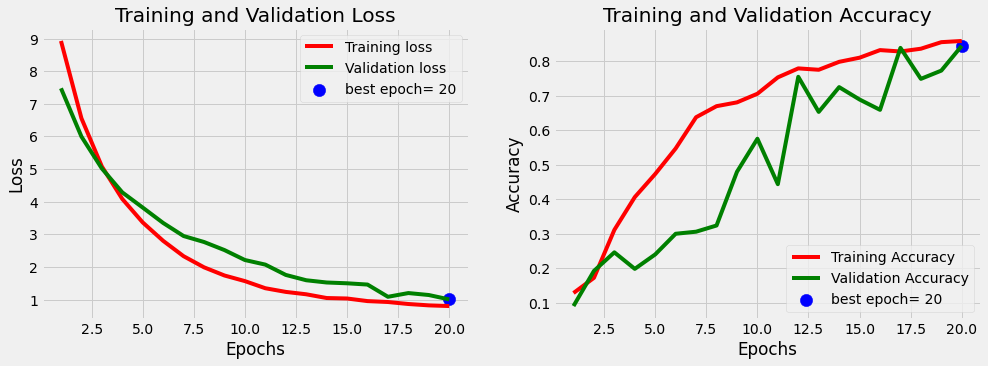

Training has completed. Now loading test set to see how accurate the model is
Model accuracy on Test Set is   84.43 %

 There were 26 errors in 167 trials for an accuracy of  84.431



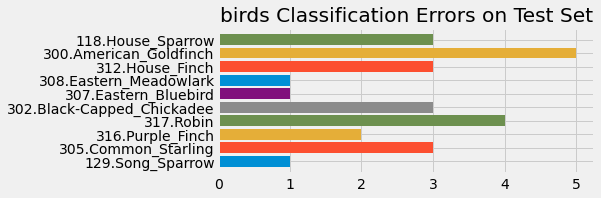

Running for 8 more epochs to see if accuracy improves
Resuming training from epoch 20
Epoch 21/28
24/24 [==============================] - ETA: 0s - loss: 0.7790 - accuracy: 0.8644 
 saving weights with new highest accuracy of   0.8644 

24/24 [==============================] - 98s 4s/step - loss: 0.7790 - accuracy: 0.8644 - val_loss: 0.9834 - val_accuracy: 0.7964
Epoch 22/28
24/24 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.8594
 current accuracy  0.8594 is below the highest accuracy of  0.8644,reducing learning rate to 0.000615217

24/24 [==============================] - 98s 4s/step - loss: 0.7657 - accuracy: 0.8594 - val_loss: 1.0413 - val_accuracy: 0.7904
Epoch 23/28
24/24 [==============================] - ETA: 0s - loss: 0.7493 - accuracy: 0.8589
 current accuracy  0.8589 is below the highest accuracy of  0.8644,reducing learning rate to 0.000305650

24/24 [==============================] - 98s 4s/step - loss: 0.7493 - accuracy: 0.8589 - val_loss: 0.9

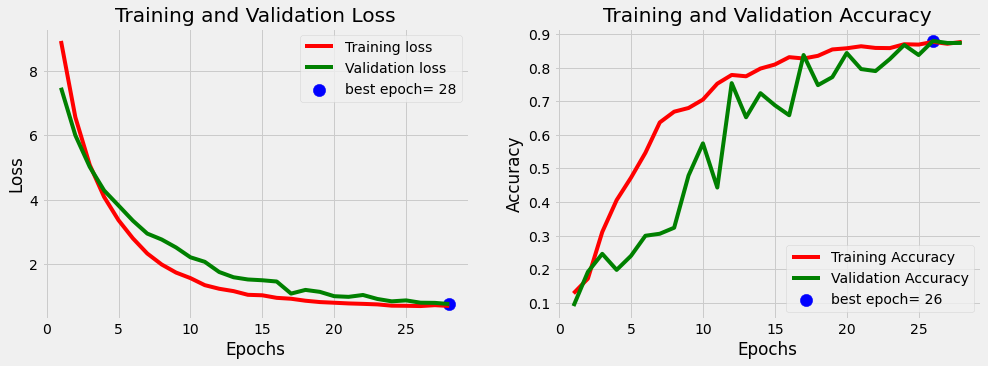

Training has completed. Now loading test set to see how accurate the model is
Model accuracy on Test Set is   88.02 %

 There were 20 errors in 167 trials for an accuracy of  88.024

     File Name              True Class          Predicted Class        Probability

       003.jpg            129.Song_Sparrow     310.Evening_Grosbeak     25.43 
       015.jpg            129.Song_Sparrow     308.Eastern_Meadowlark     55.75 
 House_Sparrow_0002_112905.jpg   305.Common_Starling    308.Eastern_Meadowlark     33.40 
 House_Sparrow_0004_111989.jpg   305.Common_Starling      316.Purple_Finch       42.46 
 House_Sparrow_0006_111034.jpg   305.Common_Starling      316.Purple_Finch       43.51 
       010.jpg               317.Robin         308.Eastern_Meadowlark     22.76 
       007.jpg          302.Black-Capped_Chickadee   310.Evening_Grosbeak     27.68 
       009.jpg          302.Black-Capped_Chickadee   310.Evening_Grosbeak     57.76 
       011.jpg          302.Black-Capped_Chickadee   310

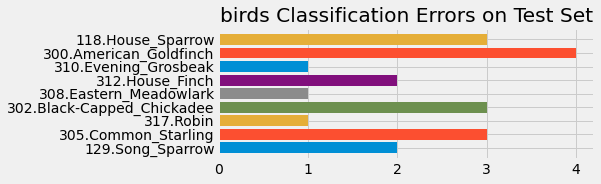

*********************Process is completed******************************


In [34]:
source_dir=r'/home/pyface2/tweetergp2/tweetersp/combined'
output_dir=r'/home/pyface2/tweetergp2/tweetersp/kerasgc'
subject='birds'
split=8
epochs=20
lr_rate=.005
image_size=224
model_size='m'
dropout=.1
rand_seed=12357
dwell=False
kaggle=True
status=TF2_classify(source_dir,output_dir,subject, split, epochs,lr_rate,image_size, model_size, dropout, rand_seed,dwell, kaggle)

In [43]:
print('end', datetime.datetime.now(pytz.timezone("America/Chicago")), 'started=', startdt)

end 2020-12-19 21:41:07.865797-06:00 started= 2020-12-19 21:40:23.284793-06:00
